***
# Project 1 - Phenotypic Prediction from Transcriptomic Features
***



## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib.pyplot as plt
import utilities
import os
import gc
import random

## Data Extraction

 Extracted the TPM value for each Accession folder and stored in the 'tpm_train.pkl' file.

In [ ]:
with open("tpm_train.pkl", 'rb') as input_file:
    data = pkl.load(input_file)
    

In [28]:
data = pd.DataFrame(data)    
data.set_index(0, inplace=True)

labels = data.iloc[:,-2:]

data.columns = [str(i) for i in data.columns]

In [29]:
X = data.drop(['199325','199326'], axis=1)
y = labels

In [30]:
X = X.astype(np.float32)

In [34]:
y.describe()

,199325,199326
count,369,369
unique,5,7
top,FIN,1
freq,77,90


In [9]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,199315,199316,199317,199318,199319,199320,199321,199322,199323,199324
0,,,,,,,,,,,,,,,,,,,,,
ERR188408,0.234074,0.0,3.67617,0.0,0.0,0.0,0.0,0.0,0.424268,0.0,...,8344.730469,47.279900,67.131699,309.765015,3487.449951,8528.700195,205.423004,5413.819824,423.902008,3361.919922
ERR188348,0.000000,0.0,1.98881,0.0,0.0,0.0,0.0,0.0,0.137385,0.0,...,7749.709961,18.325001,33.006401,23.371000,2073.770020,5866.830078,148.636002,4562.600098,360.488007,1861.000000
ERR188021,0.221792,0.0,5.42060,0.0,0.0,0.0,0.0,0.0,1.080040,0.0,...,8584.839844,35.289902,36.760399,92.426003,3532.689941,5837.020020,299.964996,3237.989990,85.903198,2026.969971
ERR188289,0.000000,0.0,8.29350,0.0,0.0,0.0,0.0,0.0,0.404072,0.0,...,7107.479980,27.253099,62.682098,87.815498,2366.439941,6055.959961,121.125000,2903.419922,459.035004,1813.839966
ERR188262,0.016667,0.0,2.00487,0.0,0.0,0.0,0.0,0.0,0.680980,0.0,...,10734.000000,28.609100,79.920303,103.341003,3527.360107,6186.930176,74.823898,5829.339844,119.750000,2343.639893


In [35]:
y.head()

,199325,199326
0,,
ERR188023,FIN,2
ERR188022,CEU,1
ERR188356,TSI,1
ERR188079,TSI,4
ERR188032,CEU,7


***
## Trying ExtraTreesClassifier on TPM for finding Feature importance

In [36]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1, bootstrap=True, oob_score=True, verbose=1,
                              random_state=0)

# using out-of-bag samples for testing generalization accuracy

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1])[:15]:
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.5s finished


Feature ranking:
1. feature 146538 (0.001027)
2. feature 26680 (0.000885)
3. feature 146526 (0.000839)
4. feature 27152 (0.000744)
5. feature 2601 (0.000743)
6. feature 188191 (0.000739)
7. feature 164230 (0.000730)
8. feature 105409 (0.000677)
9. feature 86816 (0.000675)
10. feature 168691 (0.000645)
11. feature 94604 (0.000636)
12. feature 157375 (0.000631)
13. feature 35348 (0.000617)
14. feature 175821 (0.000613)
15. feature 64611 (0.000608)


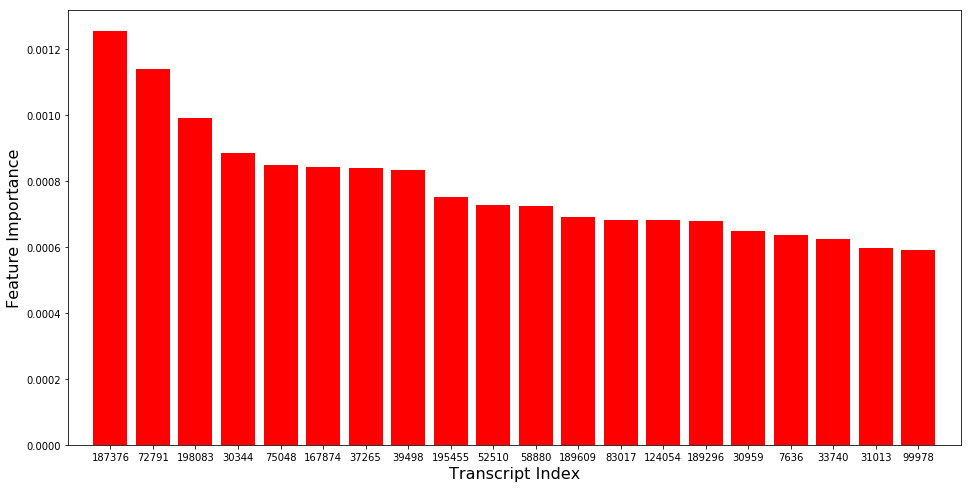

In [26]:
# Plot the feature importances of the forest
count = 20
plt.figure(figsize=(16, 8))
# plt.bar(range(X_train.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
plt.bar(range(count), importances[indices[:count]],
       color="r", align="center")

# plt.xticks(range(X_train.shape[1]), indices)
plt.xticks(range(count), indices[:count])
plt.xlim([-1, count])
plt.xlabel("Transcript Index", fontsize=16)
plt.ylabel("Feature Importance", fontsize=16)
# plt.xlim([-1, X_train.shape[1]])
plt.show()

### Dumping the variables to pickle
To save processing time for future runs

In [37]:
if not os.path.exists("indices.pkl"):
    with open("indices.pkl", 'wb') as out:
        pkl.dump(indices, out)

In [38]:
if not os.path.exists("X.pkl"):
    with open("X.pkl", 'wb') as out:
        pkl.dump(X, out)

In [39]:
if not os.path.exists("y.pkl"):
    with open("y.pkl", 'wb') as out:
        pkl.dump(y, out)

In [40]:
X = X.iloc[:, indices[:10000]]

In [41]:
if not os.path.exists("X_train_reduced.pkl"):
    with open("X_train_reduced.pkl", 'wb') as out:
        pkl.dump(X, out)

***
## Implementing PCA on the selected important features

In [34]:
pca = PCA(n_components=512)
X_new = pca.fit_transform(X)

In [35]:
X_new.shape

(369, 369)

Interesting observation, after trying PCA we get a worse answer. This is because the fact that we have very less data to train on.<br>
***

## Cross Validation on RandomForestClassifier
<br>
<b>Parameters for the Forest :</b>
- Number of trees = 200
- Max depth of a tree - 60

<b>Parameters Cross validation :</b>
- number of folds = 5

In [114]:
def avg_f1_score(y_test,y_pred):
    pop_score = f1_score(y_test[199325], y_pred[:,0], average='macro',)
    center_score = f1_score(y_test[199326], y_pred[:,1], average='macro')
    return (pop_score+center_score)/2.0
score = make_scorer(avg_f1_score, greater_is_better=True)

In [121]:
le = LabelEncoder()
le.fit(y[199325])
y_enc = y 
y_enc[199325] = le.transform(y[199325])
y_enc[199326] = y_enc[199326].astype('int') 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Random Forest New

In [155]:
# random.seed(18)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_params = {
    'n_estimators':[10,30,50,100,200,250],
    'criterion': ('gini','entropy'),
    'max_depth': [15,20,30,40,60],
    'class_weight' : (None,'balanced','balanced_subsample')
}
gcv_rf = GridSearchCV(cv=4,estimator=rf,param_grid=rf_params,n_jobs=-1,scoring=score,verbose=1)
gcv_rf.fit(X,y_enc)
# scores = cross_val_score(clf, X, y, cv=5, scoring=score)

print gcv_rf.best_estimator_

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.6min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


### Best RFC
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
            
cv=4 <br>
0.811905104099 0.0176607853188

In [158]:
print gcv_rf.best_score_

0.811829641971


In [157]:
scores = cross_val_score(gcv_rf.best_estimator_,X,y_enc, cv=4,n_jobs=-1,scoring=score,verbose=1)

print scores.mean(),scores.std()

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.2s finished


0.811905104099 0.0176607853188


# Extra Trees Classifier

In [159]:
etc = ExtraTreesClassifier(n_jobs=-1)
etc_params = {
    'n_estimators':[10,30,50,100,200,250],
    'criterion': ('gini','entropy'),
    'max_depth': [15,20,30,40,60],
    'class_weight' : (None,'balanced','balanced_subsample'),
    
}
gcv_etc = GridSearchCV(cv=4,estimator=etc,param_grid=rf_params,n_jobs=-1,scoring=score,verbose=1)
gcv_etc.fit(X,y_enc)
# scores = cross_val_score(clf, X, y, cv=5, scoring=score)

print gcv_etc.best_estimator_

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.0s
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=60, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [160]:
print gcv_etc.best_score_
scores = cross_val_score(gcv_etc.best_estimator_,X,y_enc, cv=4,n_jobs=-1,scoring=score,verbose=1)

print scores.mean(),scores.std()

0.775486198935


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.1s finished


0.777778749865 0.0137470677549


## KNN Classifiers

In [166]:
knn = KNN(n_jobs=-1)
knn_params = {
    'n_neighbors': [5,10,25,50,100],
    'weights': ['uniform','distance'],
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'p':[1,2]
}
gcv_knn = GridSearchCV(cv=4,estimator=knn,param_grid=knn_params,n_jobs=-1,scoring=score,verbose=1)
gcv_knn.fit(X,y_enc)
# scores = cross_val_score(clf, X, y, cv=5, scoring=score)

print gcv_knn.best_estimator_

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.0s
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
           weights='distance')


In [167]:
print gcv_knn.best_score_
scores = cross_val_score(gcv_knn.best_estimator_,X,y_enc, cv=4,n_jobs=-1,scoring=score,verbose=1)

print scores.mean(),scores.std()

0.669801705702


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.0s finished


0.66977957859 0.0151012433588


In [112]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)  

scaler = StandardScaler()

scores = []
count =1
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_enc.iloc[train_index], y_enc.iloc[test_index]

    X_train = scaler.fit_transform(X_train)

    clf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0, n_jobs=-1,class_weight="balanced_subsample")
    clf.fit(X_train,y_train)
    
    X_test = scaler.transform(X_test)
    y_pred = clf.predict(X_test)
#     print y_pred[:,1]
    pop_score = f1_score(y_test[199325], y_pred[:,0], average='macro')
    center_score = f1_score(y_test[199326], y_pred[:,1], average='macro')
    scores.append((pop_score+center_score)/2.0)
    print str(count) +") f1_score : ", scores[-1]
    count+=1

KFold(n_splits=5, random_state=None, shuffle=False)
1) f1_score :  0.795271667071
2) f1_score :  0.851374047154
3) f1_score :  0.797495437569
4) f1_score :  0.774835746723
5) f1_score :  0.836501830552


In [113]:
print "The average f-1 score is ",sum(scores)/len(scores)

The average f-1 score is  0.811095745814


## MLPClassifier

In [37]:
with open("indices.pkl", 'rb') as in_file:
    indices = pkl.load(in_file)

In [39]:
with open("X_train_reduced.pkl", 'rb') as in_file:
    X = pkl.load(in_file)

In [40]:
with open("y.pkl", 'rb') as in_file:
    y = pkl.load(in_file)

In [51]:
X.shape

(369, 10000)

In [52]:
## Performing 5 fold cross validation on MLP Classifier
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)  

scaler = StandardScaler()

scores = []
count =1
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = scaler.fit_transform(X_train)

    clf = MLPClassifier(hidden_layer_sizes=(256, 128), activation='logistic', #solver='lbfgs', #learning_rate='adaptive',
                    verbose=False, tol=1e-5 ,max_iter=500, learning_rate_init=0.005
#                     warm_start = True
                   )
    
    clf.fit(X_train, y_train)
    
    X_test = scaler.transform(X_test)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))
    print count,") f1_score : ", scores[-1]
    count+=1
    
    

KFold(n_splits=5, random_state=None, shuffle=False)


ValueError: Multioutput target data is not supported with label binarization

In [47]:
print "The average f-1 score is ",sum(scores)/len(scores)

The average f-1 score is  0.91048192588


***
## Future Use

Using information from equivalence classes

In [ ]:
# folder_names = utilities.get_folder_names("./train/")

# master_set = set()
# all_eq_c = {}
# count = 0
# for f in folder_names:
#     with open("./train/" + f +"/bias/aux_info/eq_classes.txt") as eq_file:
#         eq_c = eq_file.read()
#     eq_c = eq_c.strip()
#     eq_c = eq_c.split("\r\n")
#     eq_c = eq_c[199326:]
#     eq_c = np.array(eq_c)
# #     print eq_c[0]
#     cur_eq_c = {}
    
#     try:

#         for i in range(len(eq_c)):
#             e = eq_c[i].split('\t')
#             key = int(''.join(e[1:-1]))
# #             for i in range(len(e[:-1])):
# #                 e[i] = int(''.join()e[i])
#             cur_eq_c[key] = int(e[-1])
#             master_set.add(key)
#     except Exception as err:
#         print err
#         print f,i
    
#     all_eq_c[f] = cur_eq_c
#     count+=1
#     print count
#     gc.collect()
    


In [ ]:
gc.collect()

In [5]:
pkl.dump(master_set,open('master_set.pkl','wb'))

In [6]:
with open('all_eq_classes.pkl','wb') as f:
    pkl.dump(all_eq_c,f)

In [12]:
import sys
tot_size = sys.getsizeof(all_eq_c.values())
tot_size+= sum(map(sys.getsizeof,all_eq_c.itervalues()))
print tot_size/(1024*1024)

5292


In [2]:
with open('./master_set.pkl', 'rb') as f:
    master_set = pkl.load(f)
    
with open('./all_eq_classes.pkl', 'rb') as f:
    all_eq_c = pkl.load(f)

In [ ]:
for k in all_eq_c.keys():
    with open('./eq_classes/'+k+'.pkl', 'wb') as out_file:
        pkl.dump(all_eq_c[k], out_file)

In [16]:
master_set = list(master_set)
for i in range(len(master_set)):
#     print i
    cur = master_set.pop(i)
    master_set.insert(i,i)
    for folder in all_eq_c:
        if cur in all_eq_c[folder]:
            all_eq_c[folder][i] = all_eq_c[folder][cur]
            del all_eq_c[folder][cur]

In [9]:
folder_names = utilities.get_folder_names("./train/")
train = pd.DataFrame(np.zeros((len(folder_names),len(master_set))),index=folder_names)

In [13]:
del train
# for ind in train.index:
#     for eq_classes in all_eq_c[ind]:
#         train.loc[ind,eq_classes] = all_eq_c[ind][eq_classes]

In [14]:
# del master_set
gc.collect()

74

In [ ]:
f = pd.Series(list(master_set))